# Bag of Words (MLP Model)

In [245]:
pip install scikit-multilearn

In [246]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [247]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [248]:
#required libraries imported to run project
import nltk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import emoji
import re
import nltk
import seaborn as sns
import skmultilearn
from keras_tuner.tuners import Hyperband
from keras.models import Sequential, Model
from keras import layers
from keras import Input
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.multioutput import MultiOutputClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report,confusion_matrix,balanced_accuracy_score,cohen_kappa_score,roc_auc_score

In [249]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ReiPotato\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ReiPotato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ReiPotato\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ReiPotato\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [250]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_map = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [251]:
def contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")

    return text

def clean_text(text, remove_stopwords=True):
    text = emoji.demojize(text)
    text = text.lower()

    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    text = contractions(text, contractions_map)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string 

    
    # remove stopwords
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
    
    # Lemmatize each token
    lemm = nltk.stem.WordNetLemmatizer()
    text = list(map(lambda word:list(map(lemm.lemmatize, word)), text))
    words = [*map(''.join, text)]
    full_test = [*map(''.join, words)]
    return full_test

In [252]:
train_df = pd.read_csv("dataset/train.tsv",sep='\t')
val_df = pd.read_csv("dataset/dev.tsv",sep='\t')
test_df = pd.read_csv("dataset/test.tsv",sep='\t')

In [253]:
train_df['List of classes'] = train_df['emotion'].apply(lambda x: x.split(','))
val_df['List of classes'] = val_df['emotion'].apply(lambda x: x.split(','))
test_df['List of classes'] = test_df['emotion'].apply(lambda x: x.split(','))

In [254]:
import json
with open('dataset/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [255]:
emotion_file = open("dataset/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [256]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list


train_df['Emotions'] = train_df['List of classes'].apply(idx2class)
val_df['Emotions'] = val_df['List of classes'].apply(idx2class)
test_df['Emotions'] = test_df['List of classes'].apply(idx2class)



In [257]:
train_df['Mapped Emotions'] = train_df['Emotions'].apply(EmotionMapping)
val_df['Mapped Emotions'] = val_df['Emotions'].apply(EmotionMapping)
test_df['Mapped Emotions'] = test_df['Emotions'].apply(EmotionMapping)

In [258]:
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
y = pd.DataFrame(one_hot.fit_transform(train_df['Mapped Emotions']), columns=one_hot.classes_)
train_df = train_df.join(y)

y = pd.DataFrame(one_hot.fit_transform(val_df['Mapped Emotions']), columns=one_hot.classes_)
val_df = val_df.join(y)

y = pd.DataFrame(one_hot.fit_transform(test_df['Mapped Emotions']), columns=one_hot.classes_)
test_df = test_df.join(y)

In [259]:
#drop any columns that we will not be using
train_df = train_df.drop(train_df[train_df.neutral == 1].index)
train_df.drop(['neutral'], axis=1, inplace =True)
train_df=train_df.reset_index(drop=True)

val_df = val_df.drop(val_df[val_df.neutral == 1].index)
val_df.drop(['neutral'], axis=1, inplace =True)
val_df=val_df.reset_index(drop=True)

test_df = test_df.drop(test_df[test_df.neutral == 1].index)
test_df.drop(['neutral'], axis=1, inplace =True)
test_df=test_df.reset_index(drop=True)

In [260]:
train_df.drop(['emotion', 'id','List of classes', 'Emotions','Mapped Emotions'], axis=1, inplace=True)
val_df.drop(['emotion', 'id','List of classes', 'Emotions','Mapped Emotions'], axis=1, inplace=True)
test_df.drop(['emotion', 'id','List of classes', 'Emotions','Mapped Emotions'], axis=1, inplace=True)

In [261]:
#generate cleaned words and text - train data
train_df['words'] = train_df.text.apply(clean_text)
temp=list(train_df['words'])
train_df['filtered'] = [*map(' '.join, temp)]

#generate cleaned words and text - val data
val_df['words'] = val_df.text.apply(clean_text)
temp=list(val_df['words'])
val_df['filtered'] = [*map(' '.join, temp)]

#generate cleaned words and text - test data
test_df['words'] = test_df.text.apply(clean_text)
temp=list(test_df['words'])
test_df['filtered'] = [*map(' '.join, temp)]

In [262]:
def plot_accuracy(acc, val_acc):
    '''plot training accuracy and validation accuracy'''
    plt.clf() #clear any existing figures
    epochs = range(1, len(acc)+1) #get a number of epochs
    #assign values for each axis
    plt.plot(epochs, acc, 'bo', label="Accuracy")
    plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
    #set a title of graph and labels of each axis
    plt.title("Training and validation accuracy")
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_loss(loss, val_loss):
    '''plot training loss and validation loss on the graph'''
    plt.clf() #clear any existing figures
    epochs = range(1, len(loss)+1) #get a number of epochs
    #assign values for each axis
    plt.plot(epochs, loss, 'bo', label="Loss")
    plt.plot(epochs, val_loss, 'b', label="validation loss")
    #set a title of graph and labels of each axis
    plt.title("Training Loss & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [263]:
print('fm_train_text', X_train.shape)
print('fm_train_labels', y_train.shape)
print('fm_val_text', X_val.shape)
print('fm_val_labels', y_val.shape)
print('fm_test_text', X_test.shape)
print('fm_test_labels', y_test.shape)

fm_train_text (29191, 20163)
fm_train_labels (29191, 6)
fm_val_text (3660, 20163)
fm_val_labels (3660, 6)
fm_test_text (3640, 20163)
fm_test_labels (3640, 6)


In [264]:
#emotion labels - 27 labels
col = ['anger','disgust','fear','joy','sadness', 'surprise']

y_train = train_df[col]
y_val = val_df[col]
y_test = test_df[col]

print("Y train shape: ",y_train.shape)
# print("Y test shape: ",y_test.shape)

Y train shape:  (29191, 6)


In [265]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words = "english")
X_train = count_vect.fit_transform(train_df.filtered).toarray()
X_val = count_vect.transform(val_df.filtered).toarray()
X_test = count_vect.transform(test_df.filtered).toarray()

# Underfit Model

In [351]:
input_tensor = Input(shape=X_train.shape[1:])
x = layers.Dense(128, activation='relu')(input_tensor)
output_tensor = layers.Dense(6, activation='sigmoid')(x)
model_bow_underfit = Model(input_tensor, output_tensor)
model_bow_underfit.summary()

model_bow_underfit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss='binary_crossentropy',metrics=['accuracy'])
history_model_bow_underfit = model_bow_underfit.fit(X_train, y_train,epochs=5,batch_size=64,validation_data = (X_val, y_val), verbose=0)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20163)]           0         
                                                                 
 dense_12 (Dense)            (None, 128)               2580992   
                                                                 
 dense_13 (Dense)            (None, 6)                 774       
                                                                 
Total params: 2,581,766
Trainable params: 2,581,766
Non-trainable params: 0
_________________________________________________________________


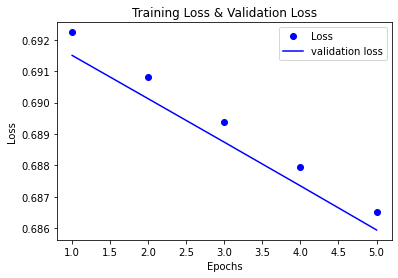

In [352]:
plot_loss(history_model_bow_underfit.history['loss'], history_model_bow_underfit.history['val_loss'])

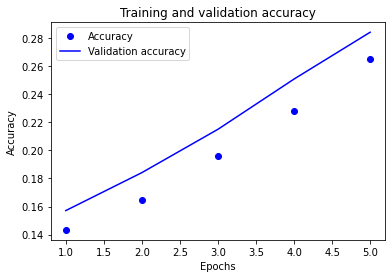

In [353]:
plot_accuracy(history_model_bow_underfit.history['accuracy'], history_model_bow_underfit.history['val_accuracy'])

# Overfit Model

In [269]:
input_tensor = Input(shape=X_train.shape[1:])
x = layers.Dense(6, activation='relu')(input_tensor)
output_tensor = layers.Dense(6, activation='sigmoid')(x)
model_bow_overfit = Model(input_tensor, output_tensor)
model_bow_overfit.summary()

model_bow_overfit.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history_model_bow_overfit = model_bow_overfit.fit(X_train, y_train,epochs=20,batch_size=64,validation_data = (X_val, y_val), verbose=0)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20163)]           0         
                                                                 
 dense_6 (Dense)             (None, 6)                 120984    
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
Total params: 121,026
Trainable params: 121,026
Non-trainable params: 0
_________________________________________________________________


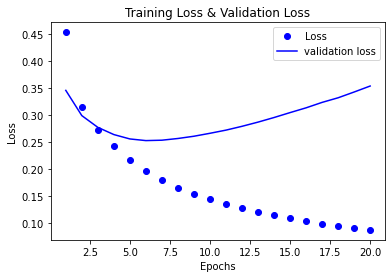

In [270]:
plot_loss(history_model_bow_overfit.history['loss'], history_model_bow_overfit.history['val_loss'])

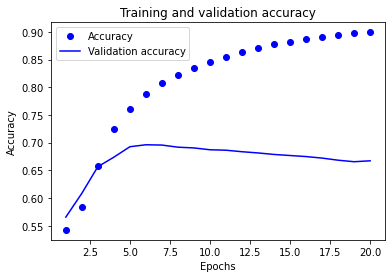

In [271]:
plot_accuracy(history_model_bow_overfit.history['accuracy'], history_model_bow_overfit.history['val_accuracy'])

# Good Model

In [354]:
input_tensor = Input(shape=X_train.shape[1:])
x = layers.Dense(64, activation='relu')(input_tensor)
output_tensor = layers.Dense(6, activation='sigmoid')(x)
model_bow_goodfit = Model(input_tensor, output_tensor)
model_bow_goodfit.summary()

model_bow_goodfit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy',metrics=['accuracy'])
history_model_bow_goodfit = model_bow_goodfit.fit(X_train, y_train,epochs=20,batch_size=256,validation_data = (X_val, y_val), verbose=0)

# input_tensor = Input(shape=X_train.shape[1:])
# x = layers.Dense(64, activation='relu')(input_tensor)
# # x = layers.Dense(124, activation='relu')(x)
# x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
# output_tensor = layers.Dense(6, activation='sigmoid')(x)
# model_bow_goodfit = Model(input_tensor, output_tensor)
# model_bow_goodfit.summary()

# model_bow_goodfit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
# history_model_bow_goodfit = model_bow_goodfit.fit(X_train, y_train,epochs=20,batch_size=258,validation_data = (X_val, y_val))


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20163)]           0         
                                                                 
 dense_14 (Dense)            (None, 64)                1290496   
                                                                 
 dense_15 (Dense)            (None, 6)                 390       
                                                                 
Total params: 1,290,886
Trainable params: 1,290,886
Non-trainable params: 0
_________________________________________________________________


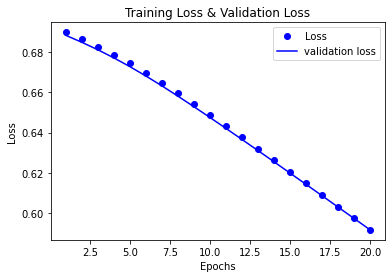

In [355]:
plot_loss(history_model_bow_goodfit.history['loss'], history_model_bow_goodfit.history['val_loss'])

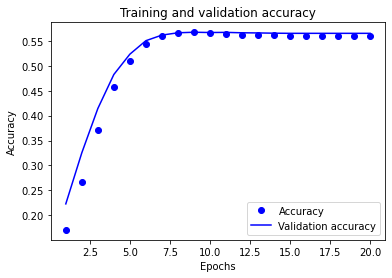

In [356]:
plot_accuracy(history_model_bow_goodfit.history['accuracy'], history_model_bow_goodfit.history['val_accuracy'])

In [357]:
test_loss, test_acc = model_bow_goodfit.evaluate(X_val, y_val)

115/115 [==============================] - 2s 13ms/step - loss: 0.5918 - accuracy: 0.5650


# Running hyper tuning based on Good Model
Attempt to achieve better accuracy

In [336]:
def model_builder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    input_tensor = Input(shape=X_train.shape[1:])
    
    x = layers.Dense(units=hp.Choice('dense1_layer', values=[16,32,64,128,256,512]), activation = 'relu',
                   kernel_regularizer=tf.keras.regularizers.L1(hp.Float('dense1_L1', min_value=0.00001, max_value=0.001)))(input_tensor)
    x = layers.Dense(units=hp.Choice('dense2_layer', values=[16,32,64,128,256,512]), activation = 'relu',
                   kernel_regularizer=tf.keras.regularizers.L1(hp.Float('dense2_L1', min_value=0.00001, max_value=0.001)))(x)
   
    output_tensor = layers.Dense(6, activation = 'sigmoid')(x)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [337]:
tuner = Hyperband(
    hypermodel=model_builder,
    max_epochs=10,
    objective='val_accuracy',
    factor=3,
    directory='bow_models/',
    project_name='bow'
)

In [338]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dense1_layer (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
dense1_L1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': None}
dense2_layer (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
dense2_L1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': None}


In [339]:
tuner.search(X_train, y_train, epochs = 30, validation_data = (X_val,y_val), batch_size= 128, callbacks = [EarlyStopping(monitor='val_loss', patience=2)])

Trial 30 Complete [00h 01m 36s]
val_accuracy: 0.6057376861572266

Best val_accuracy So Far: 0.6926229596138
Total elapsed time: 00h 14m 24s
INFO:tensorflow:Oracle triggered exit


In [362]:
best_model_tuner = tuner.hypermodel.build(best_hps)
histry_best_tunder =best_model_tuner.fit(X_train, y_train, epochs=30, validation_data=(X_val,y_val), batch_size= 128, verbose=0)

val_acc_per_epoch = histry_best_tunder.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 30


In [342]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

114/114 [==============================] - 1s 4ms/step - loss: 0.3206 - accuracy: 0.6030
[test loss, test accuracy]: [0.3205554187297821, 0.6030219793319702]


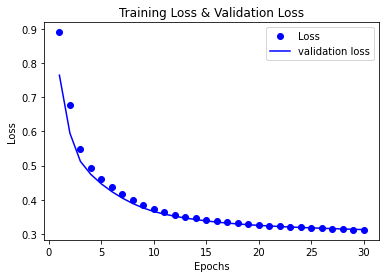

In [343]:
plot_loss(best_tuned_bow_history.history['loss'], best_tuned_bow_history.history['val_loss'])

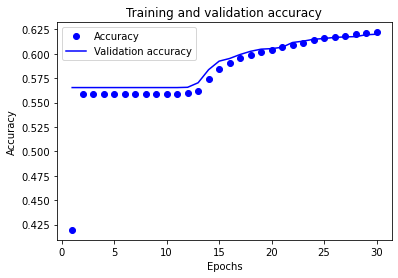

In [344]:
plot_accuracy(best_tuned_bow_history.history['accuracy'], best_tuned_bow_history.history['val_accuracy'])

In [325]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

114/114 [==============================] - 1s 5ms/step - loss: 1.3060 - accuracy: 0.6478
[test loss, test accuracy]: [1.305956244468689, 0.6478021740913391]


# Training models on full train data

In [358]:
summary_table = PrettyTable(["Loss","Accuracy","Precision","Recall","F1","Cohen Kappa","Model"])

def evaluation (x_test, y_test,x_val, y_val,model,model_name):
    test_loss, test_acc = model.evaluate(x_val, y_val)
    
    y_pred = model.predict(x_test)
    Y_test=y_test.values.argmax(axis=1)
    Y_pred = np.argmax(y_pred,axis=1)

    cm = confusion_matrix(Y_test, Y_pred)
    p = precision_score(Y_test, Y_pred, average='weighted')
    r = recall_score(Y_test, Y_pred, average='weighted')
    f = f1_score(Y_test,Y_pred, average='weighted')
    ck = cohen_kappa_score(Y_test, Y_pred)
    
    values = [test_loss,test_acc,p,r,f,ck]
    rounded_row = [round(elem, 3) for elem in values]
    rounded_row.append(model_name)
    
    summary_table.add_row(rounded_row)

In [359]:
#training - fit to input data
final_fit = model_bow_goodfit.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]), epochs=20, batch_size=256, verbose=0)
evaluation (X_test, y_test,X_val, y_val,saved_model,'manual-tuned model')

115/115 [==============================] - 2s 14ms/step - loss: 16.5554 - accuracy: 0.6790


C:\Users\ReiPotato\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [360]:
#training - fit to input data
final_fit = hypermodel.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]), epochs=best_epoch, batch_size=128, verbose=0)
evaluation (X_test, y_test,X_val, y_val,best_model_tuner,'hyper-tuned model')

115/115 [==============================] - 2s 12ms/step - loss: 0.3135 - accuracy: 0.6243


C:\Users\ReiPotato\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [361]:
print(summary_table)

+--------+----------+-----------+--------+-------+-------------+--------------------+
|  Loss  | Accuracy | Precision | Recall |   F1  | Cohen Kappa |       Model        |
+--------+----------+-----------+--------+-------+-------------+--------------------+
| 16.555 |  0.679   |   0.634   | 0.653  | 0.597 |    0.373    | manual-tuned model |
| 0.313  |  0.624   |    0.6    | 0.608  | 0.514 |    0.254    | hyper-tuned model  |
+--------+----------+-----------+--------+-------+-------------+--------------------+


In [131]:
# print(summary_table)

+-------+----------+-----------+--------+-------+-------------+-------------------+
|  Loss | Accuracy | Precision | Recall |   F1  | Cohen Kappa |       Model       |
+-------+----------+-----------+--------+-------+-------------+-------------------+
| 0.323 |  0.617   |   0.597   | 0.597  | 0.597 |    0.185    | hyper-tuned model |
| 0.578 |  0.567   |   0.545   | 0.545  | 0.545 |    0.003    |   goodfit model   |
+-------+----------+-----------+--------+-------+-------------+-------------------+
